# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(680887, 24)


,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,swing_miss,delta_run_exp,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value
0,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0,-0.073,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
1,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0,-0.027,108.0,75.3,75.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0,-0.020,157.0,83.5,65.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
3,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,1.53,6.83,5.9,54.61,0,0.016,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0,-0.189,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0


Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(24)

,feature,VIF
11,swing_miss,1.435700
7,release_pos_x,1.685610
15,launch_angle,2.508363
3,pfx_-x,3.341261
12,delta_run_exp,3.934273
4,pfx_z,5.052088
21,babip_value,5.172847
14,exit_velo,5.176083
20,woba_denom,5.194216
22,iso_value,5.934894


# Features

In [4]:
features = data[['velo', 'pfx_-x', 'pfx_z', 'delta_run_exp', 
                 'woba_value', 'babip_value', 'iso_value', 
                 'estimated_ba_using_speedangle', 
                 'estimated_woba_using_speedangle', 
                 'swing_miss',  'pitch_type']]

ff = features.loc[features['pitch_type'] == 'FF']
print('4-seam shape:', ff.shape)
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)

4-seam shape: (249672, 11)
Cutter shape: (47442, 11)
Sinker shape: (109145, 11)
Slider shape: (135539, 11)
Curveball shape: (58767, 11)
Changeup shape: (80322, 11)


# Clustering 

## 4-Seam Fastball

In [5]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)
model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print('Predicted clusters to points: ', label_ff[:10], '\n')

Number of iterations: 7
Number of features: 10
Number of clusters: 2
Inertia: 1638094.7718413887 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - 4-Seam

In [6]:
# 0 bad, 1 good

X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
velo,93.709491,93.558200
pfx_-x,2.842062,2.821841
pfx_z,16.132601,15.574475
delta_run_exp,-0.038624,0.670027
woba_value,0.023159,1.168494
babip_value,0.000081,0.813899
iso_value,0.000000,0.764685
estimated_ba_using_speedangle,0.022046,0.610139
estimated_woba_using_speedangle,0.024532,0.748993
swing_miss,0.097967,0.000000


In [7]:
#score = silhouette_score(X_ff, label_ff, metric="euclidean")
#score

### Heatmaps of Features - 4-Seam

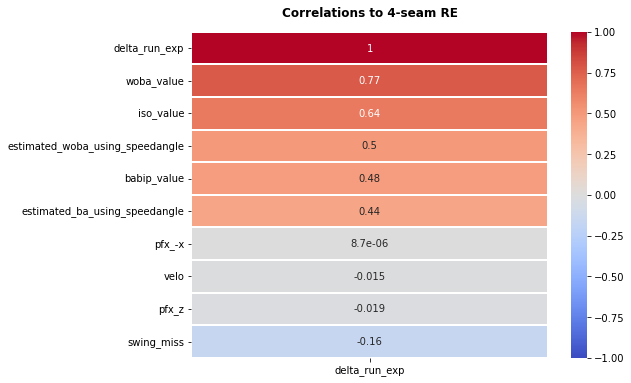

In [8]:
plt.figure(figsize = (8, 6))
sns.heatmap(ff.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam RE', fontweight = 'bold', pad = 15);

Positively correlated with label, as the positive values increase the run exp increases

Negatively correlated with lablel, as the negative values increase the run exp decreases and vice versa

Positively correlated with label, as the positive values increase the label increases

Negatively correlated with lablel, as the negative values increase the label decreases and vice versa

## Cutter

In [9]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 4
Number of features: 10
Number of clusters: 2
Inertia: 311130.3457966881 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 1 0] 



### Cluster Labels - Cutter

In [10]:
# 0 good, 1 bad

X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
velo,88.537120,88.360014
pfx_-x,-1.392300,-1.200505
pfx_z,7.928830,7.846257
delta_run_exp,-0.043880,0.677698
woba_value,0.018394,1.132094
babip_value,0.000022,0.842862
iso_value,0.000000,0.665731
estimated_ba_using_speedangle,0.025243,0.588757
estimated_woba_using_speedangle,0.026544,0.697647
swing_miss,0.117759,0.000000


### Heatmap of Features - Cutter

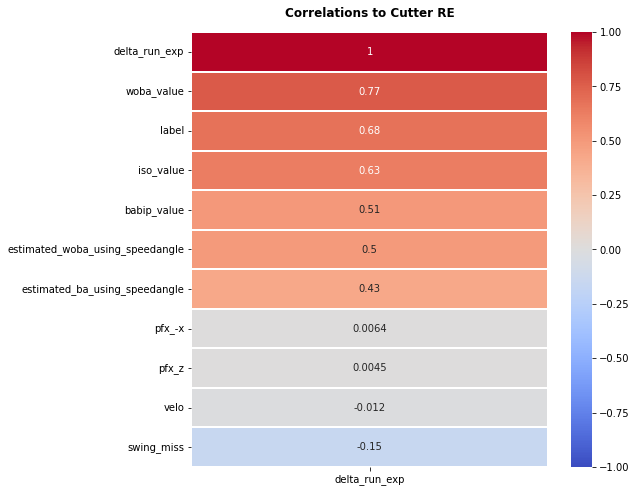

In [11]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter RE', fontweight = 'bold', pad = 15);

# Sinker

In [12]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 8
Number of features: 10
Number of clusters: 2
Inertia: 728665.5874750072 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Sinker

In [13]:
# 0 good, 1 bad

X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
velo,93.015631,92.885030
pfx_-x,5.640407,5.743059
pfx_z,9.257199,8.857963
delta_run_exp,-0.044860,0.625962
woba_value,0.024942,1.082576
babip_value,0.000020,0.878296
iso_value,0.000000,0.526707
estimated_ba_using_speedangle,0.029931,0.562477
estimated_woba_using_speedangle,0.030656,0.641823
swing_miss,0.066988,0.000000


### Heatmap of Features - Sinker

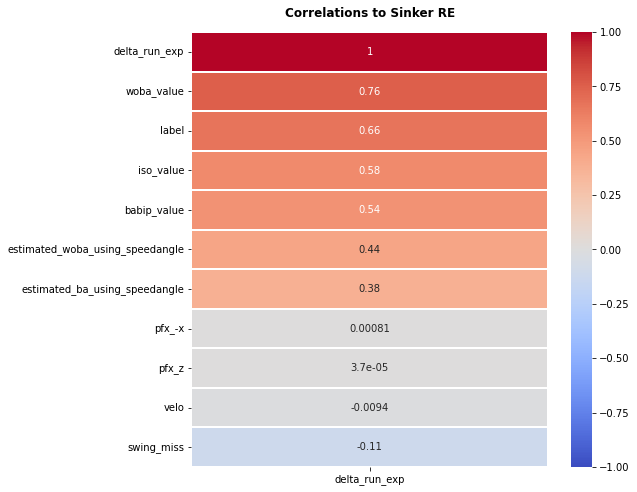

In [14]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_si.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Sinker RE', fontweight = 'bold', pad = 15);

## Slider

In [15]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 4
Number of features: 10
Number of clusters: 2
Inertia: 885773.2904635705 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Slider

In [16]:
# 0 bad, 1 good

X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
velo,84.653085,84.632906
pfx_-x,-3.228850,-3.095633
pfx_z,1.707480,1.634954
delta_run_exp,-0.041580,0.726635
woba_value,0.016000,1.151486
babip_value,0.000023,0.827385
iso_value,0.000000,0.720466
estimated_ba_using_speedangle,0.020860,0.584721
estimated_woba_using_speedangle,0.022073,0.695887
swing_miss,0.170835,0.000000


### Heatmap of Features - Slider

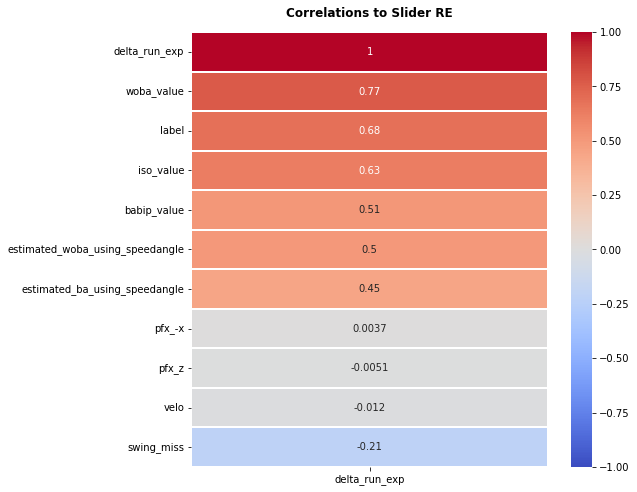

In [17]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider RE', fontweight = 'bold', pad = 15);

# Curveball

In [18]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 24
Number of features: 10
Number of clusters: 2
Inertia: 383618.71467478166 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Curveball

In [19]:
# 0 good, 1 bad

X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
velo,78.756450,78.500984
pfx_-x,-3.868649,-3.732332
pfx_z,-8.737747,-8.797522
delta_run_exp,-0.032888,0.690532
woba_value,0.012147,1.121301
babip_value,0.000000,0.854592
iso_value,0.000000,0.638848
estimated_ba_using_speedangle,0.020318,0.583561
estimated_woba_using_speedangle,0.021118,0.674107
swing_miss,0.131143,0.000000


### Heatmaps of Features - Curveball

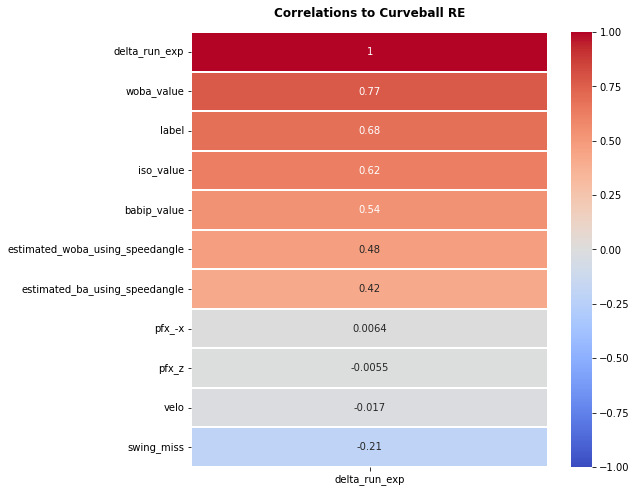

In [20]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_cu.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Curveball RE', fontweight = 'bold', pad = 15);

## Changeup

In [21]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 8
Number of features: 10
Number of clusters: 2
Inertia: 527634.5057626753 

Predicted clusters to points:  [0 0 1 0 0 0 0 0 0 0] 



### Cluster Labels - Changeup

In [22]:
# 0 good, 1 bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
velo,84.816814,84.656705
pfx_-x,3.649818,2.765732
pfx_z,6.829012,6.818959
delta_run_exp,-0.041273,0.685364
woba_value,0.015649,1.124352
babip_value,0.000040,0.851602
iso_value,0.000000,0.637681
estimated_ba_using_speedangle,0.028534,0.574957
estimated_woba_using_speedangle,0.029332,0.665303
swing_miss,0.154396,0.000000


### Heatmap of Features - Changeup

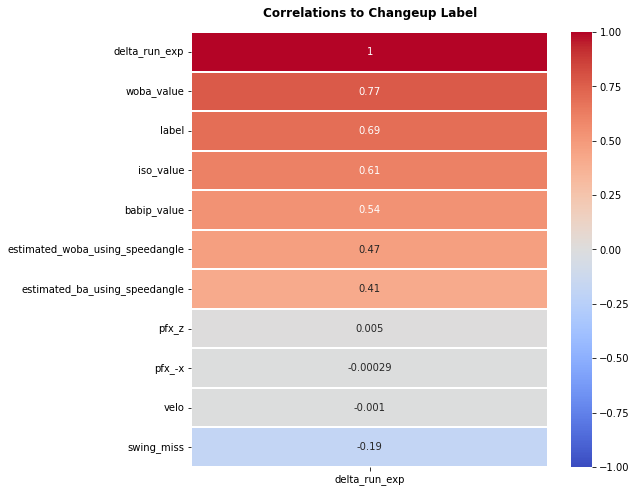

In [23]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

# Modeling

## Linear Regression - 4-Seam

In [24]:
X = X_ff.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff['delta_run_exp']

ols_model_ff = sm.OLS(y, X)
ols_model_ff = ols_model_ff.fit()
pred_ff = ols_model_ff.predict(X)
ols_model_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                 4.533e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:06:58   Log-Likelihood:             1.3072e+05
No. Observations:              249672   AIC:                        -2.614e+05
Df Residuals:                  249661   BIC:                        -2.613e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0546      0.011     -5.008      0.000      -0.076      -0.033
velo                                0.0002      0.000      1.929      0.054   -3.63e-06       0.000
pfx_-x                           1.202e-05   3.79e-05      0.317      0.751   -6.22e-05    8.63e-05
pfx_z                               0.0002   8.82e-05      2.014      0.044    4.79e-06       0.000
woba_value                          0.3970      0.002    170.744      0.000       0.392       0.402
babip_value                        -0.0102      0.007     -1.498      0.134      -0.024       0.003
iso_value                           0.1727      0.003     68.197      0.000       0.168       0.178
estimated_ba_using_speedangle      -0.3600      0.008    -47.099      0.000      -0.375      -0.345
estimated_woba_using_speedangle    -0.0224      0.006     -3.592      0.000      -0.035      -0.010
swing_miss                         -0.0910      0.001    -91.029      0.000      -0.093      -0.089
label                               0.3493      0.007     46.591      0.000       0.335       0.364
==============================================================================
Omnibus:                    68611.696   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3490417.380
Skew:                           0.528   Prob(JB):                         0.00
Kurtosis:                      21.287   Cond. No.                     3.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

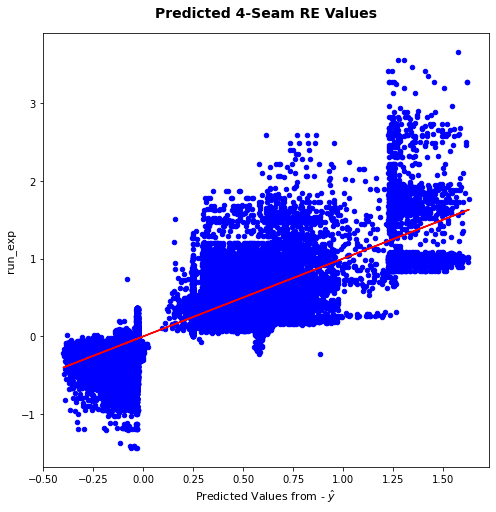

MSE: 0.0205
RMSE: 0.1433
MAE: 0.0869


In [25]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_ff, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ff, np.poly1d(np.polyfit(pred_ff, y, 1))(pred_ff), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))

## Linear Regression - Cutter

In [26]:
X = X_fc.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc['delta_run_exp']

ols_model_fc = sm.OLS(y, X)
ols_model_fc = ols_model_fc.fit()
pred_fc = ols_model_fc.predict(X)
ols_model_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     8427.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:06:58   Log-Likelihood:                 22026.
No. Observations:               47442   AIC:                        -4.403e+04
Df Residuals:                   47431   BIC:                        -4.393e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0292      0.020     -1.479      0.139      -0.068       0.009
velo                            -3.939e-05      0.000     -0.171      0.864      -0.000       0.000
pfx_-x                             -0.0001      0.000     -0.797      0.426      -0.001       0.000
pfx_z                           -5.734e-05      0.000     -0.308      0.758      -0.000       0.000
woba_value                          0.4444      0.006     70.763      0.000       0.432       0.457
babip_value                        -0.1233      0.017     -7.383      0.000      -0.156      -0.091
iso_value                           0.1091      0.006     17.835      0.000       0.097       0.121
estimated_ba_using_speedangle      -0.5076      0.018    -27.639      0.000      -0.544      -0.472
estimated_woba_using_speedangle     0.1048      0.016      6.635      0.000       0.074       0.136
swing_miss                         -0.0770      0.002    -34.232      0.000      -0.081      -0.073
label                               0.4646      0.018     25.437      0.000       0.429       0.500
==============================================================================
Omnibus:                    11266.125   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           470793.582
Skew:                           0.363   Prob(JB):                         0.00
Kurtosis:                      18.416   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

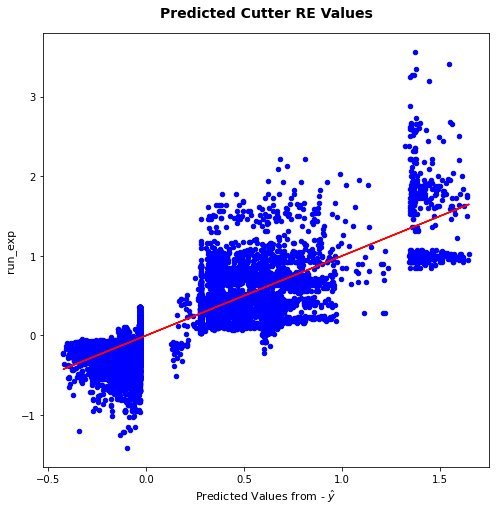

MSE: 0.0231
RMSE: 0.1521
MAE: 0.093


In [27]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_fc, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_fc, np.poly1d(np.polyfit(pred_fc, y, 1))(pred_fc), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_fc), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc), 4))

## Linear Regression - Sinker

In [28]:
X = X_si.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si['delta_run_exp']

ols_model_si = sm.OLS(y, X)
ols_model_si = ols_model_si.fit()
pred_si = ols_model_si.predict(X)
ols_model_si.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                 1.855e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:06:59   Log-Likelihood:                 49105.
No. Observations:              109145   AIC:                        -9.819e+04
Df Residuals:                  109134   BIC:                        -9.808e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0231      0.015     -1.531      0.126      -0.053       0.006
velo                               -0.0002      0.000     -1.186      0.236      -0.001       0.000
pfx_-x                          -2.305e-05   3.41e-05     -0.676      0.499   -8.99e-05    4.38e-05
pfx_z                               0.0004      0.000      4.098      0.000       0.000       0.001
woba_value                          0.4303      0.004    117.735      0.000       0.423       0.437
babip_value                        -0.0436      0.011     -4.135      0.000      -0.064      -0.023
iso_value                           0.1615      0.004     42.079      0.000       0.154       0.169
estimated_ba_using_speedangle      -0.4443      0.012    -35.865      0.000      -0.469      -0.420
estimated_woba_using_speedangle     0.0040      0.011      0.364      0.716      -0.018       0.026
swing_miss                         -0.0738      0.002    -37.960      0.000      -0.078      -0.070
label                               0.3983      0.011     35.077      0.000       0.376       0.421
==============================================================================
Omnibus:                    22631.331   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           793438.067
Skew:                           0.196   Prob(JB):                         0.00
Kurtosis:                      16.203   Cond. No.                     3.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

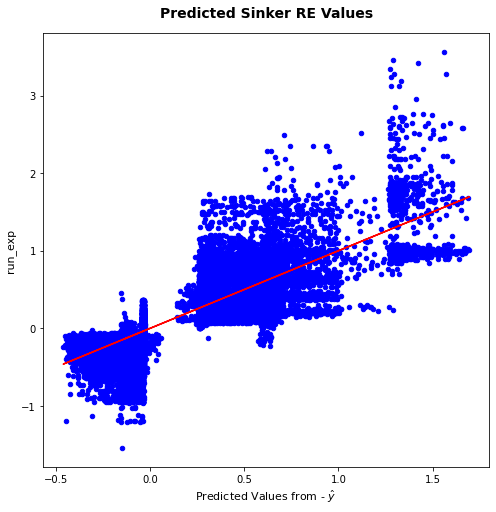

MSE: 0.0238
RMSE: 0.1543
MAE: 0.0951


In [29]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_si, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_si, np.poly1d(np.polyfit(pred_si, y, 1))(pred_si), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))

## Linear Regression - Slider

In [30]:
X = X_sl.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl['delta_run_exp']

ols_model_sl = sm.OLS(y, X)
ols_model_sl = ols_model_sl.fit()
pred_sl = ols_model_sl.predict(X)
ols_model_sl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 2.478e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:06:59   Log-Likelihood:                 67549.
No. Observations:              135539   AIC:                        -1.351e+05
Df Residuals:                  135528   BIC:                        -1.350e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0370      0.010     -3.736      0.000      -0.056      -0.018
velo                                0.0002      0.000      1.402      0.161   -6.53e-05       0.000
pfx_-x                              0.0001   5.42e-05      2.279      0.023    1.73e-05       0.000
pfx_z                              -0.0004   9.19e-05     -4.409      0.000      -0.001      -0.000
woba_value                          0.4670      0.004    122.181      0.000       0.460       0.475
babip_value                        -0.0004      0.010     -0.044      0.965      -0.020       0.019
iso_value                           0.1477      0.004     40.261      0.000       0.140       0.155
estimated_ba_using_speedangle      -0.4171      0.011    -37.058      0.000      -0.439      -0.395
estimated_woba_using_speedangle     0.0366      0.010      3.810      0.000       0.018       0.055
swing_miss                         -0.0994      0.001    -90.590      0.000      -0.102      -0.097
label                               0.3254      0.011     29.836      0.000       0.304       0.347
==============================================================================
Omnibus:                    35184.399   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1630661.561
Skew:                           0.470   Prob(JB):                         0.00
Kurtosis:                      19.966   Cond. No.                     3.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

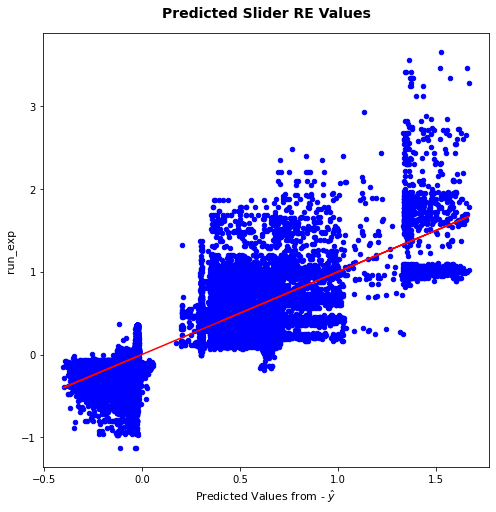

MSE: 0.0216
RMSE: 0.147
MAE: 0.0905


In [31]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_sl, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_sl, np.poly1d(np.polyfit(pred_sl, y, 1))(pred_sl), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_sl), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl), 4))

## Linear Regression - Curveball

In [32]:
X = X_cu.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu['delta_run_exp']

ols_model_cu = sm.OLS(y, X)
ols_model_cu = ols_model_cu.fit()
pred_cu = ols_model_cu.predict(X)
ols_model_cu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.119e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:06:59   Log-Likelihood:                 36076.
No. Observations:               58767   AIC:                        -7.213e+04
Df Residuals:                   58756   BIC:                        -7.203e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0462      0.012     -3.951      0.000      -0.069      -0.023
velo                                0.0003      0.000      2.277      0.023    4.62e-05       0.001
pfx_-x                            7.67e-05   5.49e-05      1.396      0.163    -3.1e-05       0.000
pfx_z                              -0.0004   9.61e-05     -4.032      0.000      -0.001      -0.000
woba_value                          0.4694      0.006     79.965      0.000       0.458       0.481
babip_value                        -0.0089      0.014     -0.641      0.521      -0.036       0.018
iso_value                           0.1334      0.005     25.874      0.000       0.123       0.143
estimated_ba_using_speedangle      -0.4429      0.016    -27.478      0.000      -0.474      -0.411
estimated_woba_using_speedangle     0.0560      0.014      3.947      0.000       0.028       0.084
swing_miss                         -0.1052      0.002    -63.797      0.000      -0.108      -0.102
label                               0.3243      0.015     21.044      0.000       0.294       0.354
==============================================================================
Omnibus:                    19710.411   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1247536.271
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                      25.517   Cond. No.                     3.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

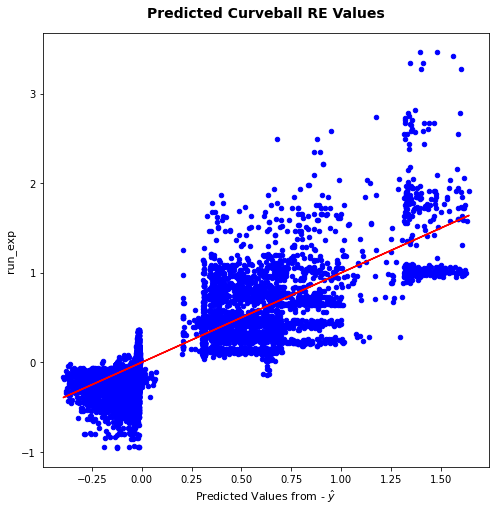

MSE: 0.0172
RMSE: 0.131
MAE: 0.0787


In [33]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_cu, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_cu, np.poly1d(np.polyfit(pred_cu, y, 1))(pred_cu), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_cu), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu), 4))

## Linear Regression - Changeup

In [34]:
X = X_ch.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ch['delta_run_exp']

ols_model_ch = sm.OLS(y, X)
ols_model_ch = ols_model_ch.fit()
pred_ch = ols_model_ch.predict(X)
ols_model_ch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:07:00   Log-Likelihood:                 39201.
No. Observations:               80322   AIC:                        -7.838e+04
Df Residuals:                   80311   BIC:                        -7.828e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0424      0.013     -3.212      0.001      -0.068      -0.017
velo                                0.0002      0.000      1.543      0.123   -6.48e-05       0.001
pfx_-x                           4.975e-05   3.99e-05      1.247      0.212   -2.84e-05       0.000
pfx_z                              -0.0001      0.000     -1.351      0.177      -0.000    6.57e-05
woba_value                          0.4359      0.005     85.945      0.000       0.426       0.446
babip_value                        -0.0046      0.012     -0.375      0.708      -0.029       0.019
iso_value                           0.1502      0.005     32.633      0.000       0.141       0.159
estimated_ba_using_speedangle      -0.4115      0.014    -29.606      0.000      -0.439      -0.384
estimated_woba_using_speedangle     0.0011      0.012      0.086      0.931      -0.023       0.025
swing_miss                         -0.0874      0.002    -57.948      0.000      -0.090      -0.084
label                               0.3622      0.014     26.749      0.000       0.336       0.389
==============================================================================
Omnibus:                    18348.466   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           716650.583
Skew:                           0.329   Prob(JB):                         0.00
Kurtosis:                      17.619   Cond. No.                     3.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

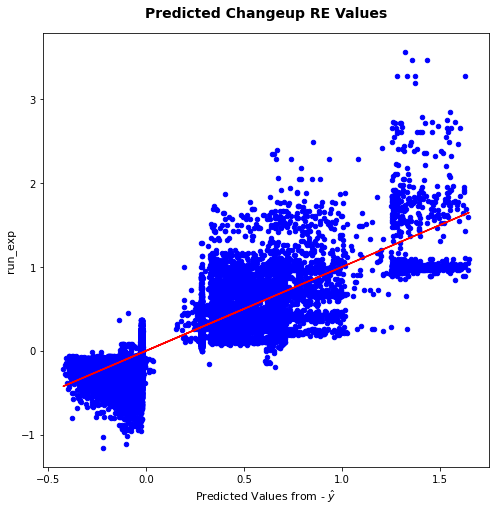

MSE: 0.0221
RMSE: 0.1485
MAE: 0.0935


In [35]:
plt.figure(figsize = (8, 8))
plt.scatter(pred_ch, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ch, np.poly1d(np.polyfit(pred_ch, y, 1))(pred_ch), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ch), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch), 4))